Here are the functions used during data preprocessing, training, and testing:

In [23]:
def train(model, x_train_tensor, y_train_tensor, criterion, optimizer, epochs):
    running_acc = []  # Move this outside the loop to accumulate values

    for epoch in range(epochs):
        model.train()
        
        # Forward Pass
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Accuracy calculation
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions = (predicted_labels == y_train_tensor).sum().item()
        total_samples = len(y_train_tensor)
        acc = correct_predictions / total_samples
        
        running_acc.append(acc)
        
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')
    
    # Plotting after training
    df_acc = pd.DataFrame({'Epochs': range(1, epochs + 1), 'Accuracy': running_acc})
    df_acc.plot(x='Epochs', y='Accuracy', kind='line', title='Training Accuracy Over Epochs', grid=True)






Import all the necessary libraries

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from transformers import AutoModel, AutoTokenizer
from transformers.models.bert.modeling_bert import BertIntermediate, BertOutput, BertEncoder, BertSelfAttention, BertSelfOutput, BertModel, BertConfig
import pandas as pd

Import the question sets that will be used to train the model.  The first dataset used was the RACE dataseet, which consists of multiple choice questions separated between M (middle school) and H (high school).  The second dataset is QxGrade_dataset which is a set of 26k questions scraped from pdf textbooks.  These textbooks were chosen based on alignment with Common Core State Standards to identify a framework that we can use when training the model with additional data. 

In [25]:
df = pd.read_csv('QxGrade_Dataset.csv')

Because I already ran through the whole process, I now know the model is training to specific levels too highly.  Now, I'm going to normalize the dataset to fix this.  To start we are going to see how many questions there are for each grade.

In [26]:
grade_counts = df['Grade'].value_counts().sort_index()
print("Grade Distribution:\n", grade_counts)

Grade Distribution:
 Grade
3      418
4     1191
5     1658
6      549
7     1153
8     1805
9     8668
10    2704
11    7288
12    1125
Name: count, dtype: int64


The two most important columns we will be using and labeling are Grade and Question.  Using the .values and .tolist function here we are adding all of the grade options (3-12) to the grades function.  We are doing the same with all of the question values.

In [27]:
x = df.question.values.tolist()  ##X is questions
y = df.Grade.astype(str).tolist() ##Y is answers

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Tokenize the data

In [29]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
x_train = tokenizer(x_train, padding=True, truncation=True, return_tensors='pt', max_length=32)
x_test = tokenizer(x_test, padding=True, truncation=True, return_tensors='pt', max_length=32)
y_train = tokenizer(y_train, padding=True, truncation=True, return_tensors='pt', max_length=32)
y_test = tokenizer(y_test, padding=True, truncation=True, return_tensors='pt', max_length=32)


In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
x_train_tensor = x_train['input_ids'].to(device)
y_train_tensor = y_train['input_ids']

y_test_tensor = y_test['input_ids'].to(device)
x_test_tensor = y_test['input_ids'].to(device)

Here are the modifications we made to the Bert model to implement Dual Multihead Attention Mechanisms and multiclass classification

In [32]:
##This implements a copy of the original attention mechnism to run simultaneously, then at the end, the outputs are joined together
class DualBertAttention(nn.Module):
    
    
    def __init__(self, config):
        super().__init__()
        
        self.attention1 = BertSelfAttention(config)
        self.attention2 = BertSelfAttention(config)
        
        self.output1 = BertSelfOutput(config)
        self.output2 = BertSelfOutput(config)
        
        
    def forward(self, hidden_states, attention_mask=None, head_mask=None):
        attn_output1 = self.attention1(hidden_states, attention_mask, head_mask)[0]  # Unpacking tuple
        attn_output1 = self.output1(attn_output1, hidden_states)

        attn_output2 = self.attention2(hidden_states, attention_mask, head_mask)[0]  # Unpacking tuple
        attn_output2 = self.output2(attn_output2, hidden_states)

        dual_attention_output = F.relu(attn_output1 + attn_output2)
        return dual_attention_output
    
##Implements the dual attention in the Neural Network
class DualBertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = DualBertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)


##Moves the data through the Neural Network
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        attention_output = self.attention(hidden_states, attention_mask, head_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return (layer_output,)


##Implments the outcome from the DualBertLayer to encode the data from the DualBertLayer Class
class DualBertEncoder(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        self.layer = nn.ModuleList([DualBertLayer(config) for _ in range(config.num_hidden_layers)])


##Implements the model with the DualBertEncoder
class DualBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.encoder = DualBertEncoder(config)



class BertClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=64, output_dim=6):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer_1 = nn.Linear(embedding_dim * 32, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)           
        x = x.view(x.size(0), -1)       
        x = torch.relu(self.layer_1(x)) 
        x = torch.relu(self.layer_2(x))
        x = self.layer_3(x)             
        return x



Using the network we create, instantiate our version of bert

In [33]:
bert = AutoModel.from_pretrained("bert-base-uncased")
config = BertConfig()  
bert = DualBertModel(config) 

Create the hyperparameters.  You can tinker with training times, sizes, and loops here.

In [34]:
epochs = 50  ##How many times we go through the loop
criterion = nn.CrossEntropyLoss()  ##This compares the predicted answer with the correct answer
optimizer = optim.SGD(bert.parameters(), lr=0.01) ##The Optim.Adam optimizer calculates gradient descent
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  ##Set the device to GPU so we can train the model on the GPU

sequence_length = 156   ## Maximum length of tokens to be used at a time
batch_size = 8  ##The number of training examples in one forward/backward pass
input_dim = 500  ##The total number of dimension we will allow the model to use for calculation
d_model = 512  ##Number of expected features, set to default recommended by pytorch
running_acc = []  ##This is to agregate the training data
save_every = 1 ##Saves the model after each epoch
PATH = 'bert_checkpoint.pt'

in_features = x_train_tensor.shape[1]
num_classes = len(set(y))

Move the model and an instance of the classifier to the GPU

In [35]:
bert_classifier = BertClassifier(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=num_classes  # e.g., 6
).to(device)


Use Bert to classify the data -- Running this training function requires approximately 37-38 gb of VRam

Epoch [10/50], Loss: 2.2955, Accuracy: 0.0008
Epoch [20/50], Loss: 2.2955, Accuracy: 0.0008
Epoch [30/50], Loss: 2.2955, Accuracy: 0.0008
Epoch [40/50], Loss: 2.2955, Accuracy: 0.0008
Epoch [50/50], Loss: 2.2955, Accuracy: 0.0008


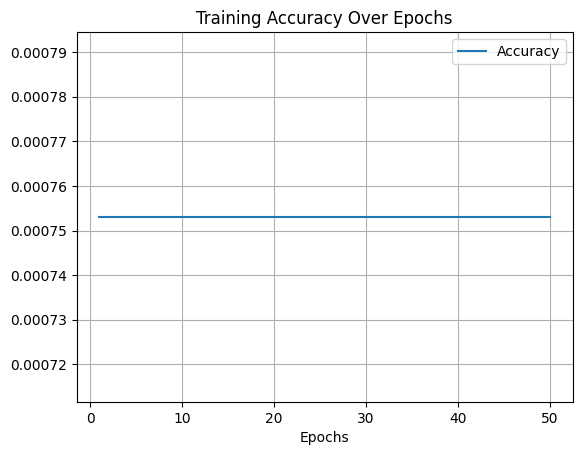

In [39]:
train(bert_classifier, x_train_tensor, y_train_tensor, criterion, optimizer, epochs)
